In [1]:
import pandas as pd
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import numpy as np
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.base import ForecastingHorizon
from sklearn.metrics import mean_squared_error
from sktime.utils.plotting import plot_series

import warnings

warnings.filterwarnings("ignore")

In [2]:
def generate_step_predictions(rolling_prediction_df, y_test_full, num_steps):
    step_predictions = []
    
    for step in range(0, num_steps):
        
        diag_values = np.diag(rolling_prediction_df.values, -step)
        
        index_range = y_test_full.index[step:step + len(diag_values)]

        column_name = f'{step+1}_step_prediction'
        
        prediction_df = pd.DataFrame(diag_values, index=index_range, columns=[column_name])
        
        if y_test_full[step:step + len(prediction_df)].index.equals(prediction_df.index):
            step_predictions.append(prediction_df)
        else:
            print(f"Error: Index mismatch for {step}-step prediction.")
    
    return step_predictions

In [3]:
X = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/filtered_features_medium.csv",
    parse_dates=["date"],
    index_col="date",
)

y = pd.read_csv(
    "https://raw.githubusercontent.com/slalom-ubc-mds/Power-Price-Prediction/main/data/processed/filtered_target_medium.csv",
    parse_dates=["date"],
    index_col="date",
)

X = X.sort_values(by="date")
X = X.asfreq("H")
y = y.sort_values(by="date")
y = y.asfreq("H")

y[y < 5] = 5

X = X[:"2023-02-10"]
y = y[:"2023-02-10"]

columns_to_multiply = []

for column in X.columns:
    if column.endswith("_reserve_margin"):
        X[column] = X[column] * 100
        columns_to_multiply.append(column)

for column in X.columns:
    if column.endswith("_supply_mix"):
        X[column] = X[column] * 100
        columns_to_multiply.append(column)

for column in X.columns:
    if column.endswith("_ratio"):
        X[column] = X[column] * 100
        columns_to_multiply.append(column)

X["renewable_energy_penetration"] = X["renewable_energy_penetration"] * 1000
X["relative_gas_reserve"] = X["relative_gas_reserve"] * 1000
X["load_on_gas_reserve"] = X["load_on_gas_reserve"] * 1000


difference = list(
    set(X.columns) - set(columns_to_multiply) - set(list(X.columns[X.lt(0).any()]))
)

X["gas_cost"] = X["gas_cost"] / 1000

In [4]:
# Train test split
forecast_len = 12

test_size = 24 * 10

y_train, y_test_full, X_train, X_test = temporal_train_test_split(
    y, X, test_size=test_size + forecast_len
)
y_test = y_test_full.iloc[:-forecast_len]

y_train = y_train.asfreq("H")
y_test = y_test.asfreq("H")
X_train = X_train.asfreq("H")
X_test = X_test.asfreq("H")


forecast_len = 12
y_test = y_test_full.iloc[:-forecast_len]

In [5]:
from sktime.forecasting.compose import make_reduction
from sktime.transformations.series.boxcox import LogTransformer
from lightgbm import LGBMRegressor
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.compose import ColumnwiseTransformer


def initialize_lgbm_forecaster():
    pipe = ForecastingPipeline(
        steps=[
            (
                "price_column_transformer",
                ColumnwiseTransformer(LogTransformer(), columns=difference),
            ),
            (
                "forecaster",
                TransformedTargetForecaster(
                    [
                        ("LogTransformer", LogTransformer()),
                        (
                            "forecast",
                            make_reduction(
                                LGBMRegressor(
                                    device="gpu", num_threads=7, n_estimators=200
                                ),
                                window_length=24,
                                strategy="direct",
                            )
                        )
                    ]
                )
            )
        ]
    )

    return pipe


def initialize_lgbm_forecaster_low():
    pipe = ForecastingPipeline(
        steps=[
            (
                "price_column_transformer",
                ColumnwiseTransformer(LogTransformer(), columns=difference),
            ),
            (
                "forecaster",
                TransformedTargetForecaster(
                    [
                        ("LogTransformer", LogTransformer()),
                        (
                            "forecast",
                            make_reduction(
                                LGBMRegressor(
                                    device="gpu",
                                    num_threads=7,
                                    n_estimators=200,
                                    objective="quantile",
                                    alpha=0.025,
                                ),
                                window_length=24,
                                strategy="direct",
                            )
                        )
                    ]
                )
            )
        ]
    )

    return pipe


def initialize_lgbm_forecaster_high():
    pipe = ForecastingPipeline(
        steps=[
            (
                "price_column_transformer",
                ColumnwiseTransformer(LogTransformer(), columns=difference),
            ),
            (
                "forecaster",
                TransformedTargetForecaster(
                    [
                        ("LogTransformer", LogTransformer()),
                        (
                            "forecast",
                            make_reduction(
                                LGBMRegressor(
                                    device="gpu",
                                    num_threads=7,
                                    n_estimators=200,
                                    objective="quantile",
                                    alpha=0.975,
                                ),
                                window_length=24,
                                strategy="direct",
                            )
                        )
                    ]
                )
            )
        ]
    )

    return pipe


lgbm_pipeline = initialize_lgbm_forecaster()
lgbm_pipeline_low = initialize_lgbm_forecaster_low()
lgbm_pipeline_high = initialize_lgbm_forecaster_high()

fh = ForecastingHorizon(np.arange(1, 12 + 1))

In [6]:
rolling_prediction_df = pd.DataFrame(index=y_test_full.index)
rolling_prediction_low_df = pd.DataFrame(index=y_test_full.index)
rolling_prediction_high_df = pd.DataFrame(index=y_test_full.index)

In [7]:
lgbm_pipeline.fit(y=y_train, X=X_train, fh=fh)
lgbm_pipeline_low.fit(y=y_train, X=X_train, fh=fh)
lgbm_pipeline_high.fit(y=y_train, X=X_train, fh=fh)

[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7


ForecastingPipeline(steps=[('price_column_transformer',
                            ColumnwiseTransformer(columns=['hydro_tng',
                                                           'rolling_max',
                                                           'rolling_std',
                                                           'system_load',
                                                           'rolling_mean',
                                                           'rolling_min',
                                                           'wind_tng',
                                                           'system_marginal_price_sum',
                                                           'renewable_energy_penetration',
                                                           'exp_moving_avg',
                                                           'northwest',
                                                           'volume_avg',
                                                           'volume_sum',
                                                           'gas_tng', 'calgary',
                                                           'weekly_profile',
                                                           'rolling_median',
                                                           'system_marginal_price_avg'],
                                                  transformer=LogTransformer())),
                           ('forecaster',
                            TransformedTargetForecaster(steps=[('LogTransformer',
                                                                LogTransformer()),
                                                               ('forecast',
                                                                DirectTabularRegressionForecaster(estimator=LGBMRegressor(alpha=0.975, device='gpu', n_estimators=200, num_threads=7,
              objective='quantile'),
                                                                                                  window_length=24))]))])

In [8]:
y_pred = lgbm_pipeline.predict(fh, X=X_train.tail(1))
y_pred.columns = [f"cutoff_hour_{lgbm_pipeline.cutoff.hour[0]}"]
rolling_prediction_df = pd.concat([rolling_prediction_df, y_pred], axis=1)


y_pred_lower = lgbm_pipeline_low.predict(fh, X=X_train.tail(1))
y_pred_lower.columns = [f"cutoff_hour_{lgbm_pipeline_low.cutoff.hour[0]}"]
rolling_prediction_low_df = pd.concat([rolling_prediction_low_df, y_pred_lower], axis=1)

y_pred_higher = lgbm_pipeline_high.predict(fh, X=X_train.tail(1))
y_pred_higher.columns = [f"cutoff_hour_{lgbm_pipeline_high.cutoff.hour[0]}"]
rolling_prediction_high_df = pd.concat([rolling_prediction_high_df, y_pred_higher], axis=1)

In [9]:
# emulating the rolling prediction for the next hours

for i in range(0, len(y_test)):

        new_observation_y, new_observation_X  = y_test[i:i+1], X_test[i:i+1]
        
        new_observation_y = new_observation_y.asfreq('H')
        new_observation_X = new_observation_X.asfreq('H')

        print(f'Updating with actual values at {new_observation_y.index[0]}')
        print(f'Cut off before update: {lgbm_pipeline.cutoff}')

        lgbm_pipeline.update(y=new_observation_y, X=new_observation_X, update_params=True)
        lgbm_pipeline_low.update(y=new_observation_y, X=new_observation_X, update_params=False)
        lgbm_pipeline_high.update(y=new_observation_y, X=new_observation_X, update_params=False)

        print(f'Cut off after update: {lgbm_pipeline.cutoff}')

        lgbm_pipeline.cutoff.freq = 'H'

        cutoff_time = lgbm_pipeline.cutoff
        prediction_for = cutoff_time + pd.DateOffset(hours=i)

        print(f'Predicting for {prediction_for}')
        
        y_pred = lgbm_pipeline.predict(fh, X=new_observation_X)
        y_pred_lower = lgbm_pipeline_low.predict(fh, X=new_observation_X)
        y_pred_higher = lgbm_pipeline_high.predict(fh, X=new_observation_X)
        
        y_pred.columns = [f"cutoff_hour_{lgbm_pipeline.cutoff.hour[0]}"]
        y_pred_lower.columns = [f"cutoff_hour_{lgbm_pipeline_low.cutoff.hour[0]}"]
        y_pred_higher.columns = [f"cutoff_hour_{lgbm_pipeline_high.cutoff.hour[0]}"]
        
        rolling_prediction_df = pd.concat([rolling_prediction_df, y_pred], axis=1)
        rolling_prediction_low_df = pd.concat([rolling_prediction_low_df, y_pred_lower], axis=1)
        rolling_prediction_high_df = pd.concat([rolling_prediction_high_df, y_pred_higher], axis=1)
        
        print(f'Update and prediction done for {new_observation_y.index[0]}')
        print(f'----------------------------------------------------------------------------------')

Updating with actual values at 2023-01-31 12:00:00
Cut off before update: DatetimeIndex(['2023-01-31 11:00:00'], dtype='datetime64[ns]', name='date', freq='H')
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
Cut off after update: DatetimeIndex(['2023-01-31 12:00:00'], dtype='datetime64[ns]', name='date', freq='H')
Predicting for DatetimeIndex(['2023-01-31 12:00:00'], dtype='datetime64[ns]', name='date', freq=None)
Update and prediction done for 2023-01-31 12:00:00
----------------------------------------------------------------------------------
Updating with actual values at 2023-01-31 13:00:00
Cut off before update: DatetimeIndex(['2023-01-31 12:00:00'], dtype='datetime64[ns]', name='date', freq='H')
[LightGBM] [Warning] num_threads is set=7, n_jobs=-1 will be ignored. Current value: num_threads=7
Cut off after update: DatetimeIndex(['2023-01-31 13:00:00'], dtype='datetime64[ns]', name='date', freq='H')
Predicting for DatetimeIndex([

In [20]:
predictions = generate_step_predictions(rolling_prediction_df, y_test_full, forecast_len)
predictions_low = generate_step_predictions(rolling_prediction_low_df, y_test_full, forecast_len)
predictions_high = generate_step_predictions(rolling_prediction_high_df, y_test_full, forecast_len)

In [21]:
step_sizes = np.arange(1, forecast_len+1)
actuals = []
rmses = []
for step, prediction_series in zip(step_sizes, predictions):
    filtered_test = y_test_full[step-1:step-1+len(prediction_series)]
    
    if filtered_test.index.equals(prediction_series.index):
        actual = y_test_full[step-1:step-1+len(prediction_series)]['price']
        actuals.append(actual)
        
        rmse = mean_squared_error(actual, prediction_series, squared=False)
        print(f"{step} Step RMSE for model: {rmse}")
        rmses.append(rmse)
    else:
        print(f"Error: Index mismatch for {step}-step prediction.")

1 Step RMSE for model: 56.00725958031994
2 Step RMSE for model: 64.7935425583549
3 Step RMSE for model: 68.6493936465649
4 Step RMSE for model: 74.96876495853837
5 Step RMSE for model: 75.82566454069662
6 Step RMSE for model: 75.27243588185448
7 Step RMSE for model: 78.31718854175797
8 Step RMSE for model: 79.97892440186926
9 Step RMSE for model: 79.23022602614091
10 Step RMSE for model: 79.89876983645632
11 Step RMSE for model: 79.72626667092469
12 Step RMSE for model: 80.7479284815696


In [22]:
print(f"Average RMSE for model: {np.mean(rmses)}")

Average RMSE for model: 74.45136376042068


In [23]:
rmse_list = []
fold_actuals = []
fold_predictions_list = []
fold_predictions_low_list = []
fold_predictions_high_list = []

for col in range(rolling_prediction_df.shape[1]):
    
    fold_predictions = rolling_prediction_df.iloc[:, col].dropna()
    fold_predictions_low = rolling_prediction_low_df.iloc[:, col].dropna()
    fold_predictions_high = rolling_prediction_high_df.iloc[:, col].dropna()
    
    fold_indices = fold_predictions.index  

    y_test_subset = y_test_full.loc[fold_indices]  
    
    rmse = np.sqrt(mean_squared_error(y_test_subset, fold_predictions))  
    
    rmse_list.append(rmse)

    fold_actuals.append(y_test_subset)
    fold_predictions_list.append(fold_predictions)
    fold_predictions_low_list.append(fold_predictions_low)
    fold_predictions_high_list.append(fold_predictions_high)

In [24]:
import pickle
with open("fold_actuals.pkl", "wb") as f:
    pickle.dump(fold_actuals, f)

with open("fold_predictions_list.pkl", "wb") as f:
    pickle.dump(fold_predictions_list, f)

with open("fold_predictions_low_list.pkl", "wb") as f:
    pickle.dump(fold_predictions_low_list, f)

with open("fold_predictions_high_list.pkl", "wb") as f:
    pickle.dump(fold_predictions_high_list, f)


fold_actuals = pd.read_pickle('fold_actuals.pkl')
fold_predictions_list = pd.read_pickle('fold_actuals.pkl')

fold_predictions_low_list = pd.read_pickle('fold_actuals.pkl')
fold_predictions_high_list = pd.read_pickle('fold_actuals.pkl')

In [25]:
# Print Average RMSE of all folds
print(f"Average RMSE for each fold: {np.mean(rmse_list)}")

Average RMSE for each fold: 48.24428663441856


In [30]:
# find folds with the highest price
highest_price_folds = []
highest_price_folds_predictions = []
highest_price_folds_low = []
highest_price_folds_high = []

for i in range(len(fold_actuals)):
    mean = fold_actuals[i].mean()
    if  mean[0] > 100:
        highest_price_folds.append(fold_actuals[i])
        highest_price_folds_predictions.append(fold_predictions_list[i])
        highest_price_folds_low.append(fold_predictions_low_list[i])
        highest_price_folds_high.append(fold_predictions_high_list[i])

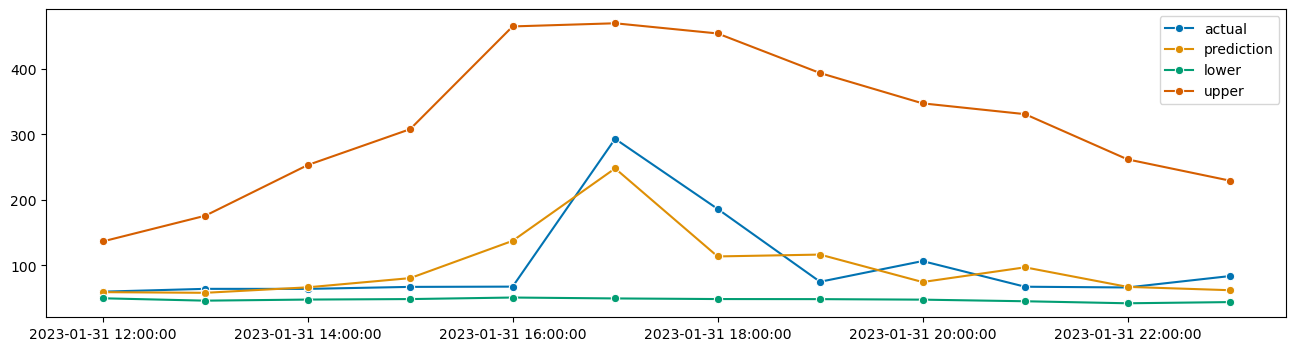

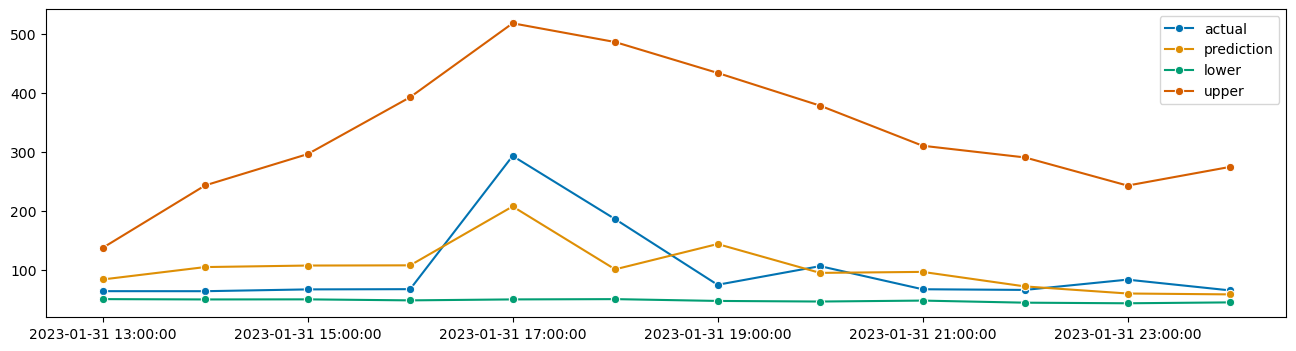

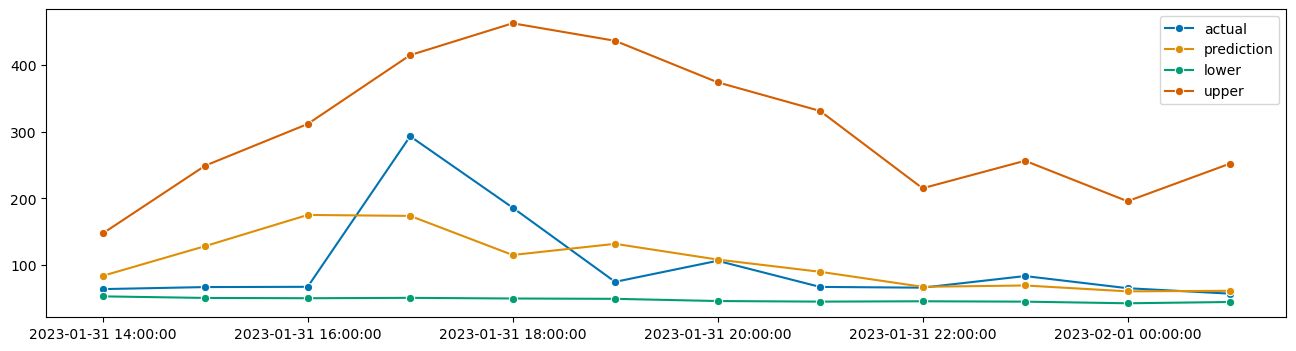

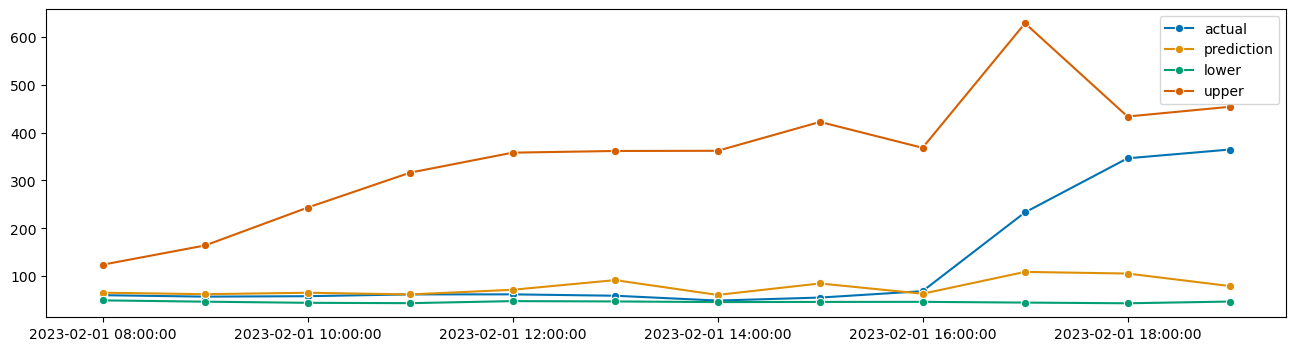

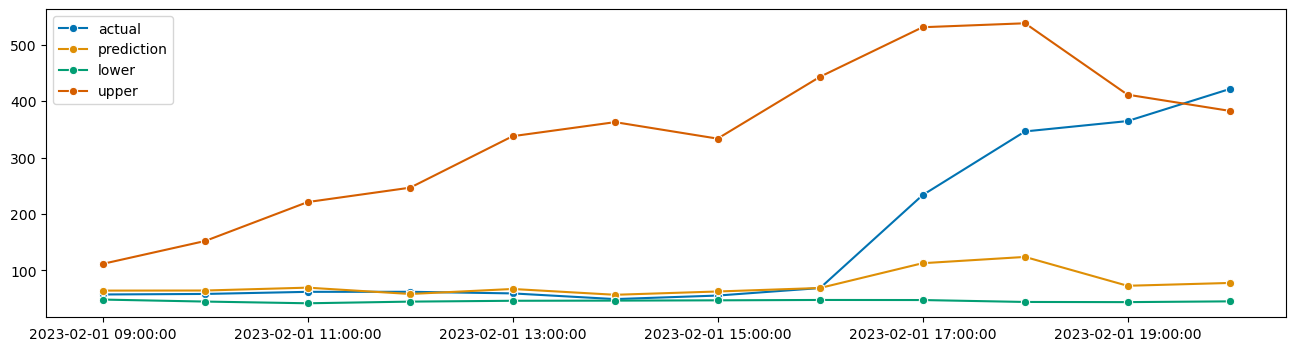

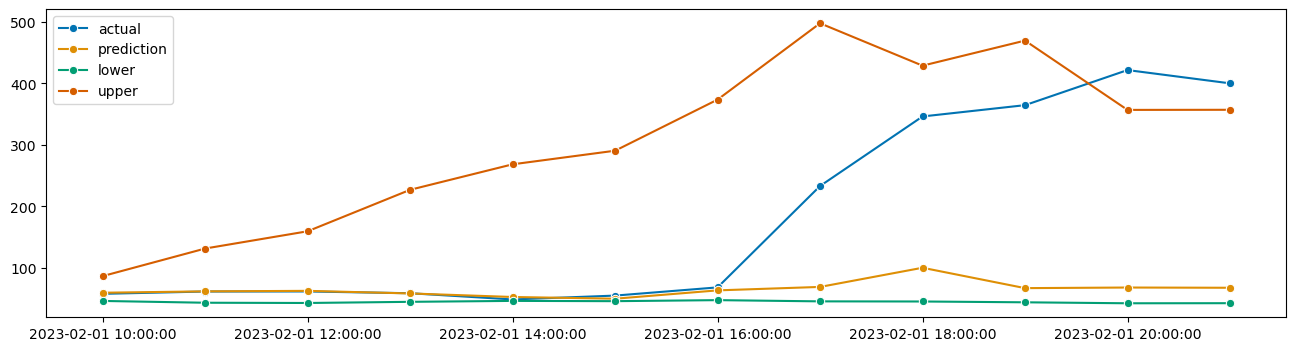

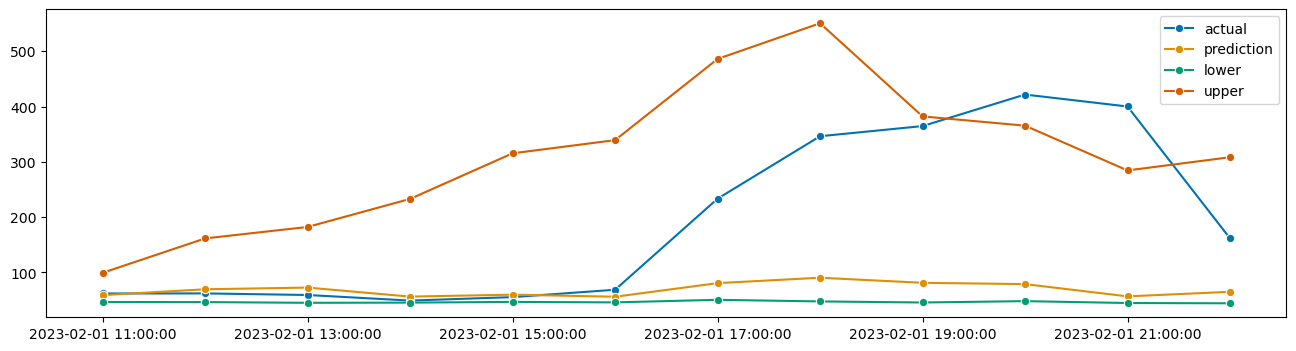

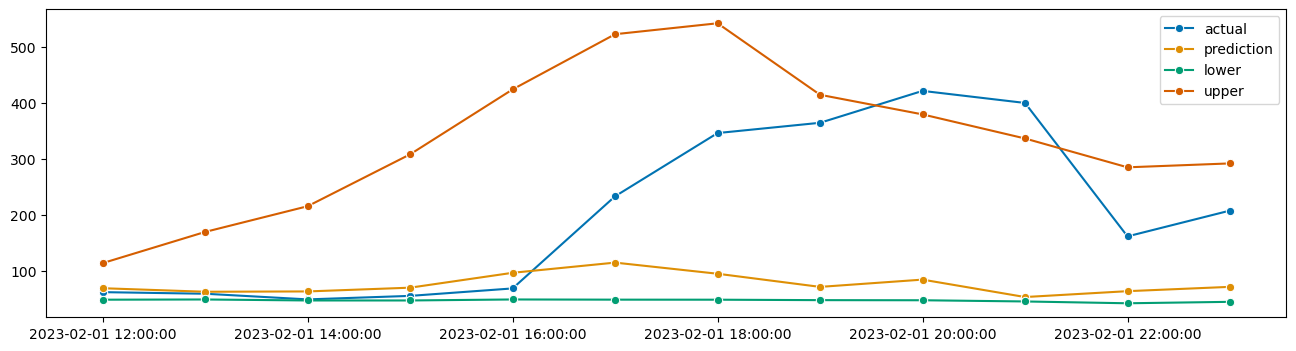

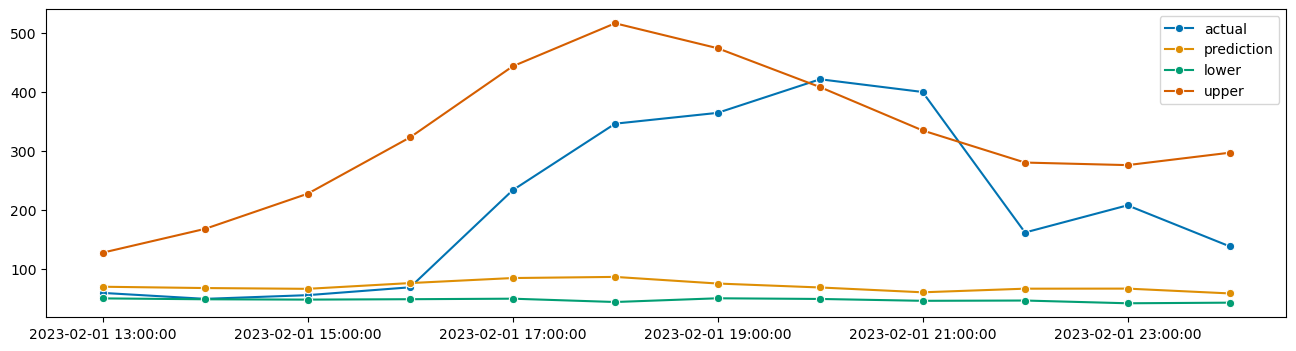

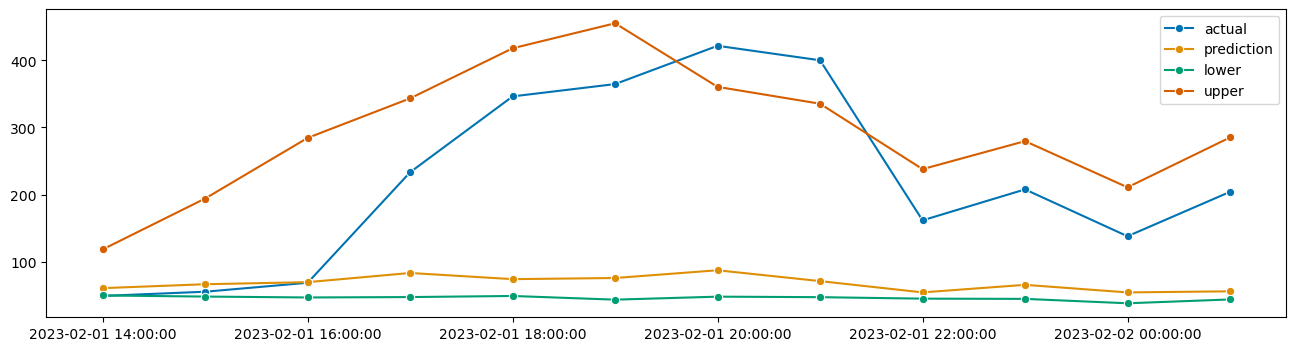

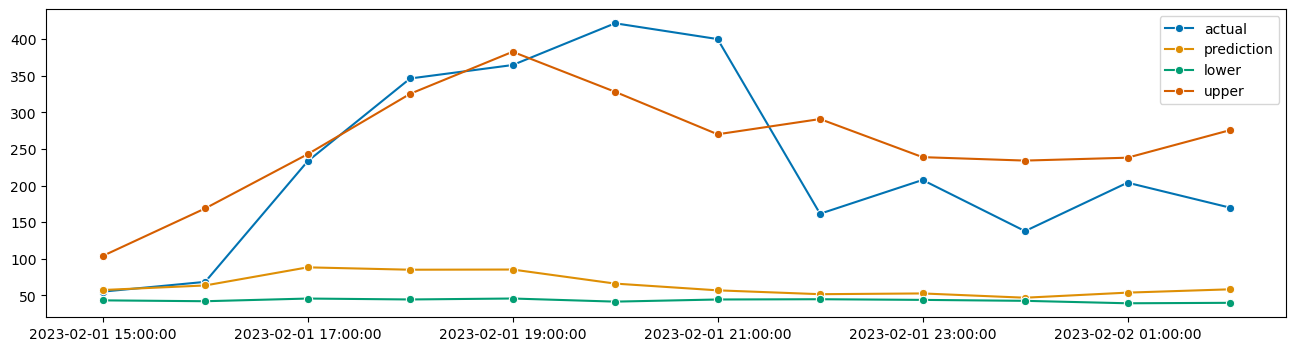

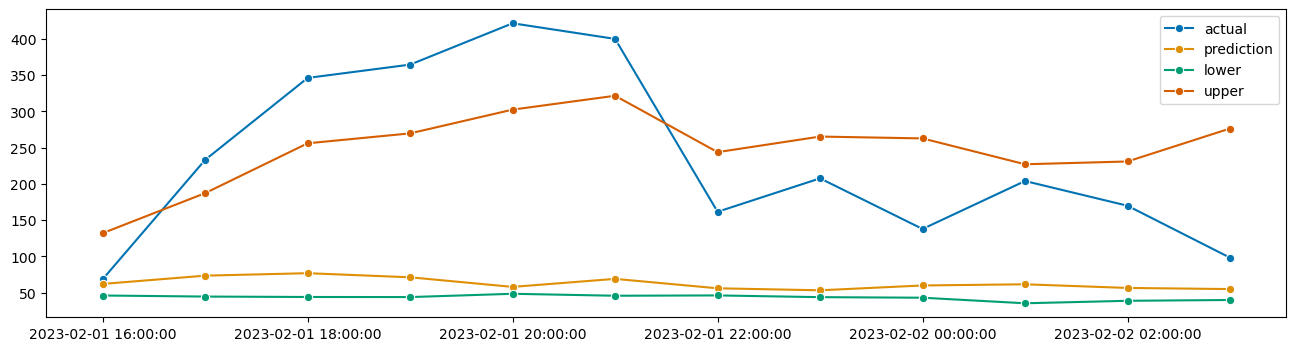

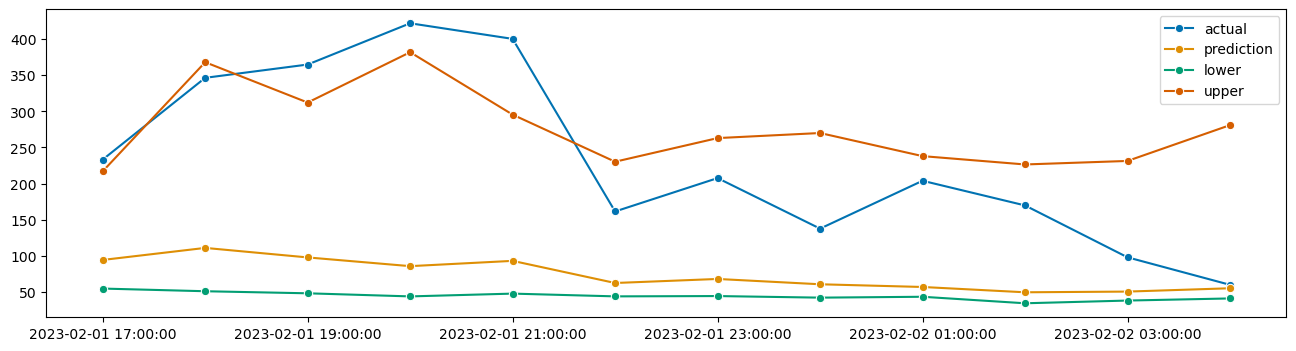

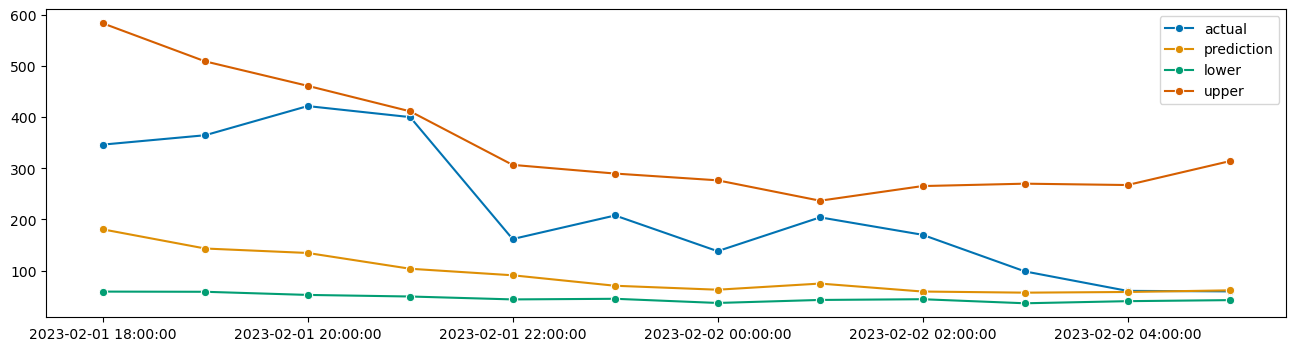

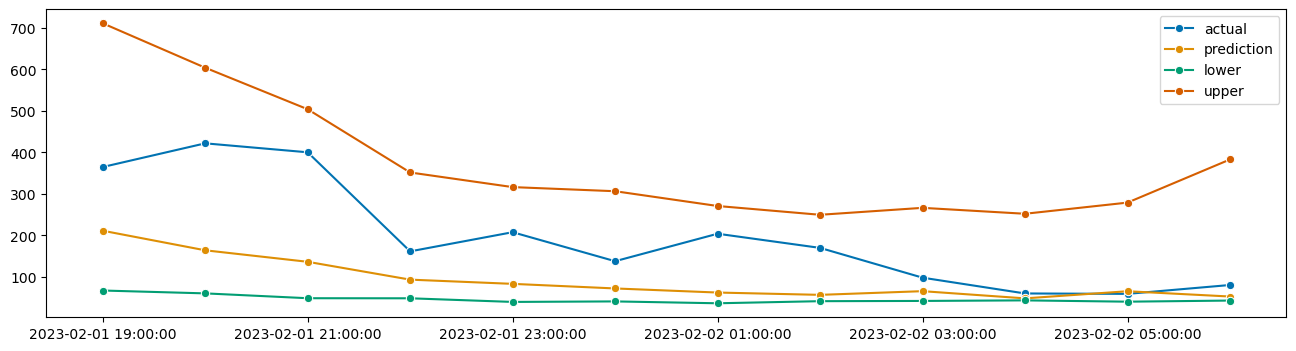

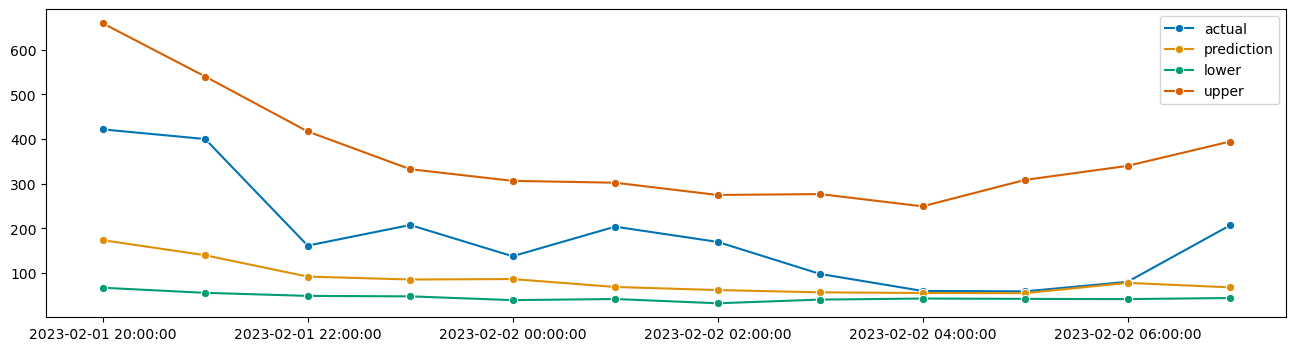

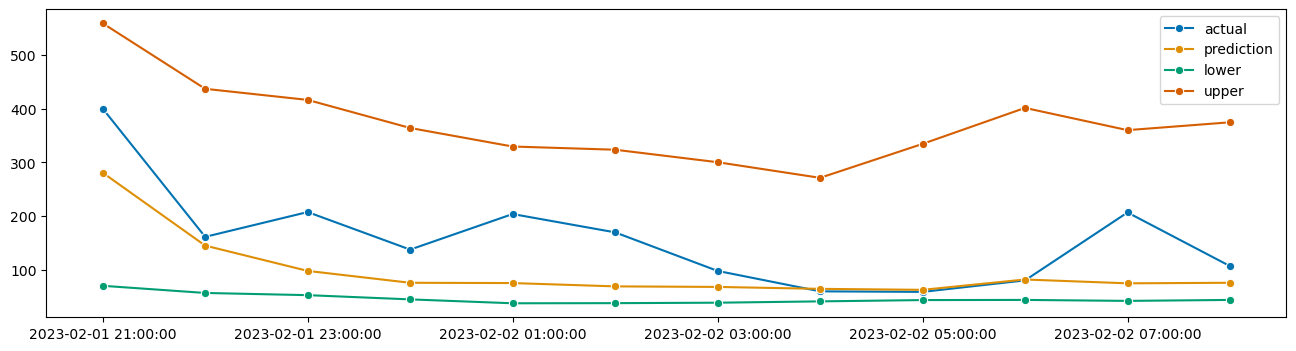

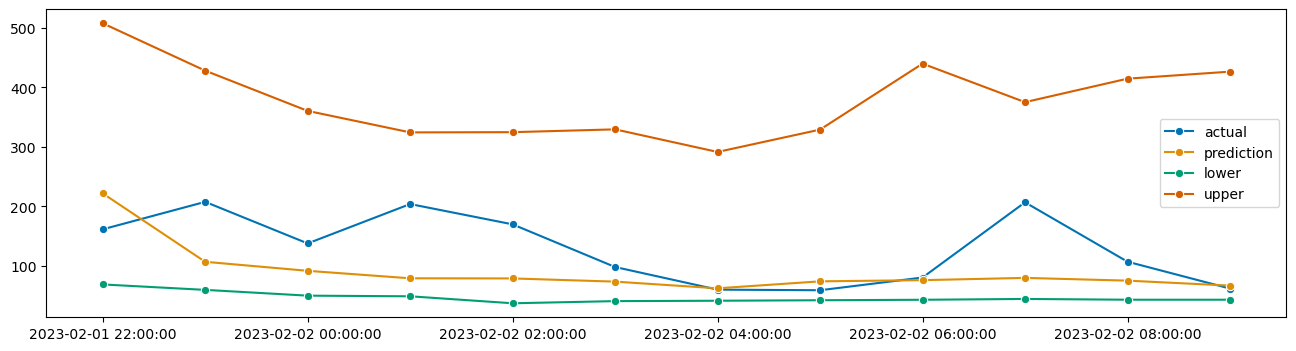

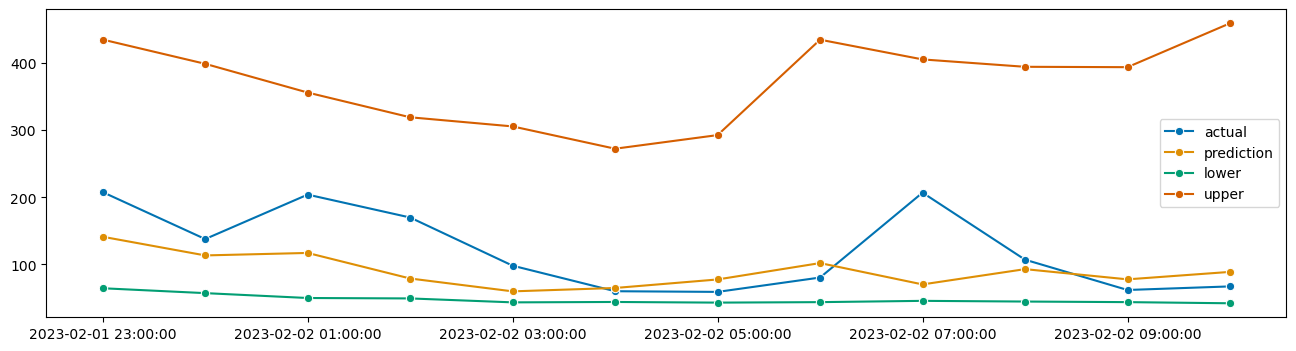

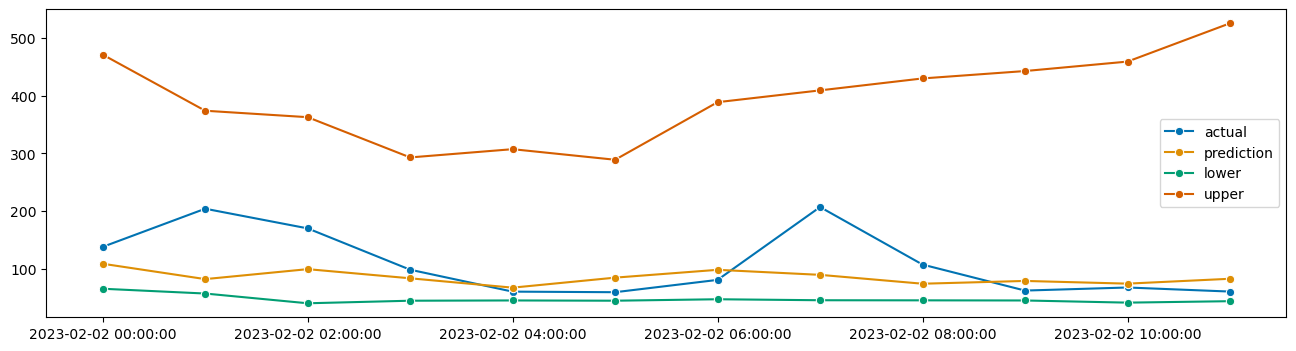

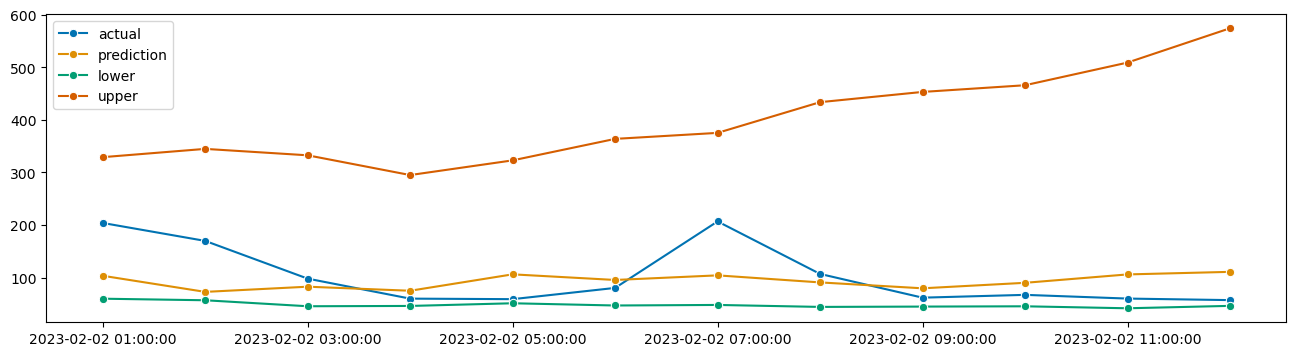

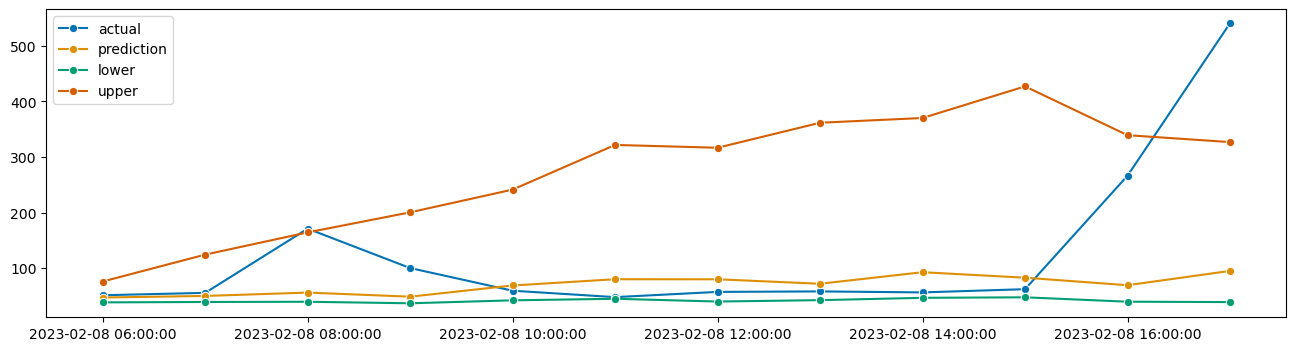

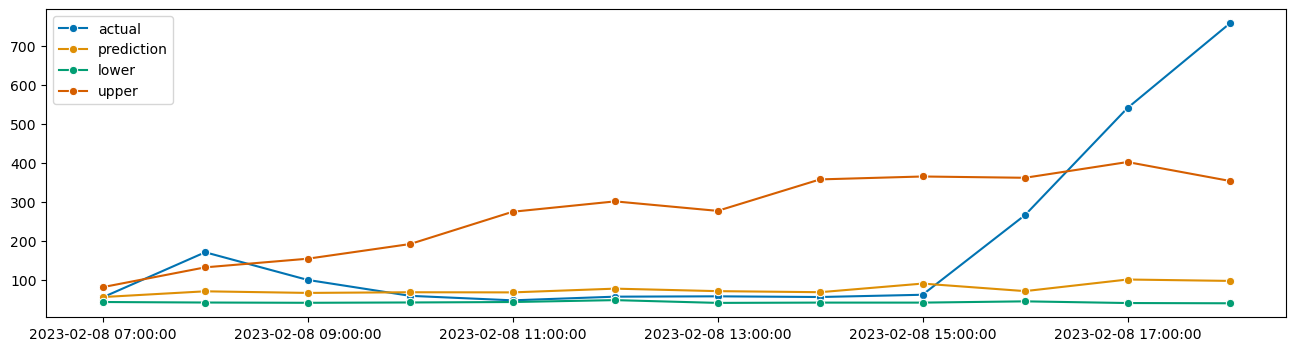

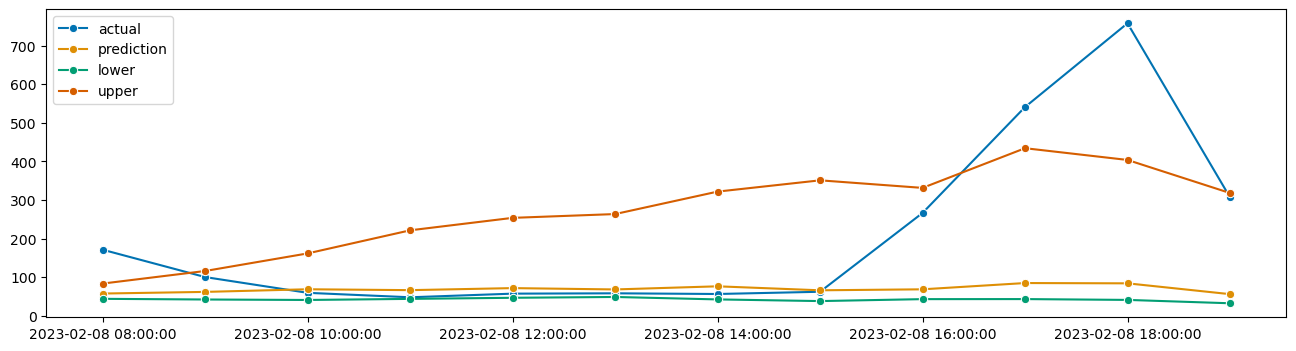

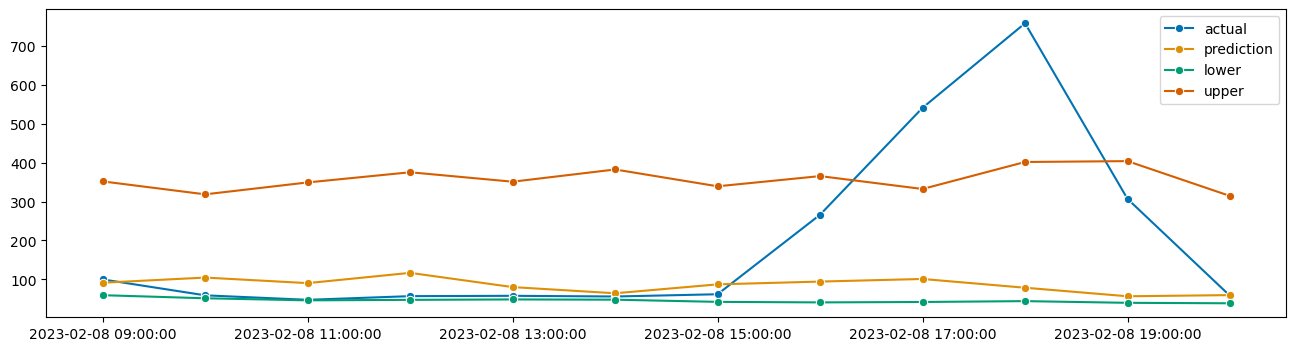

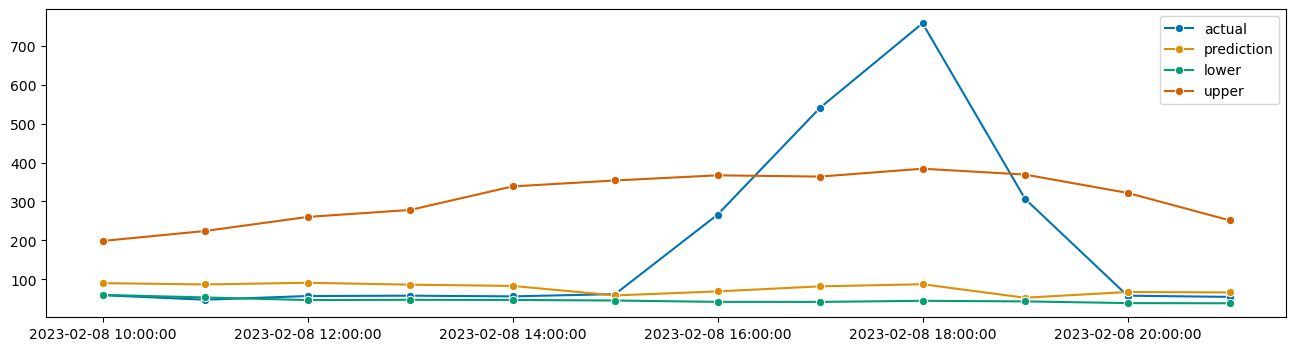

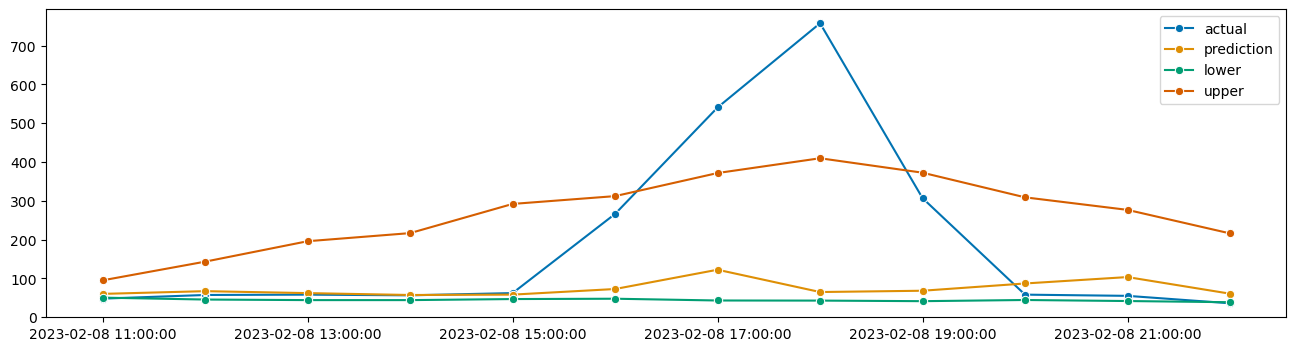

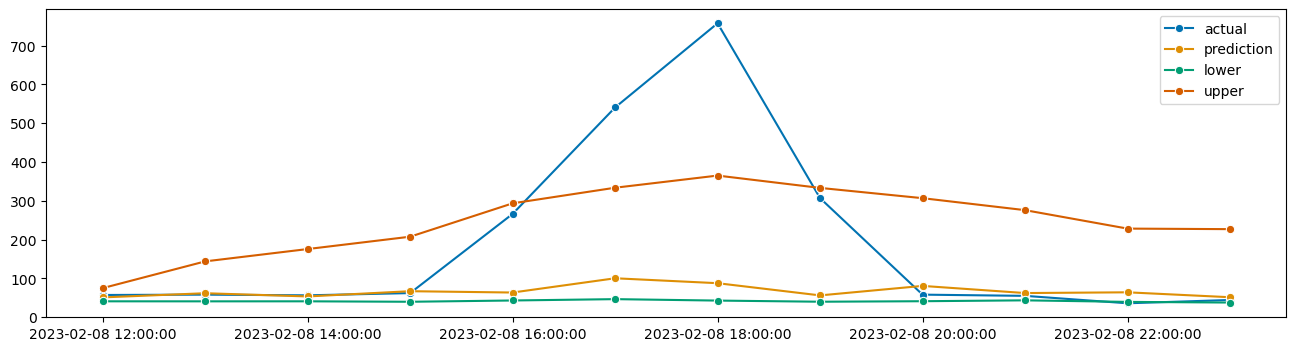

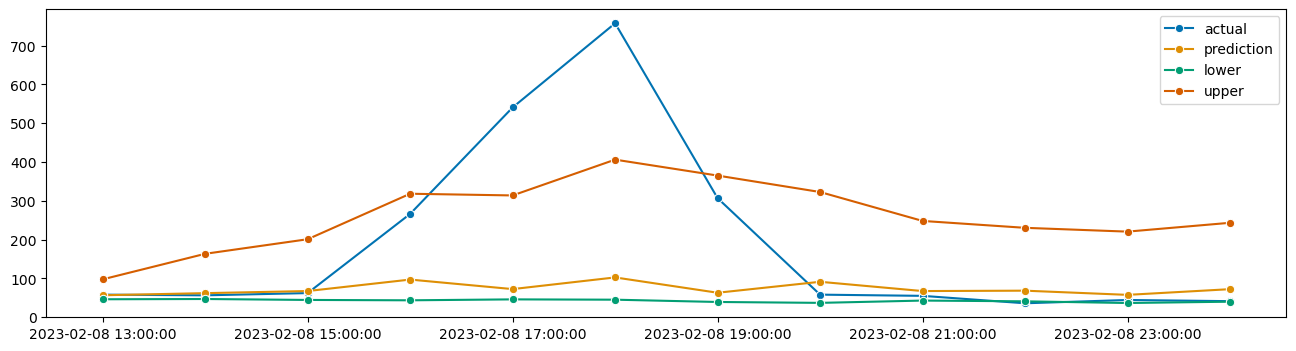

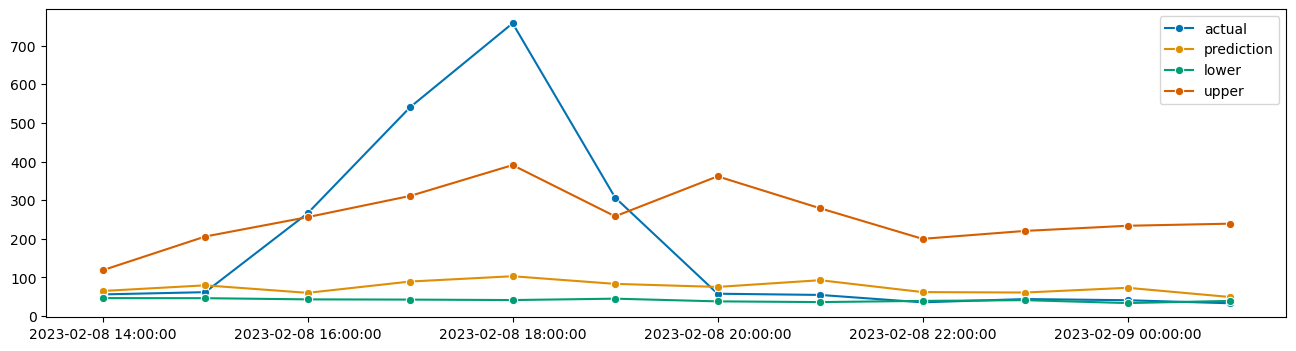

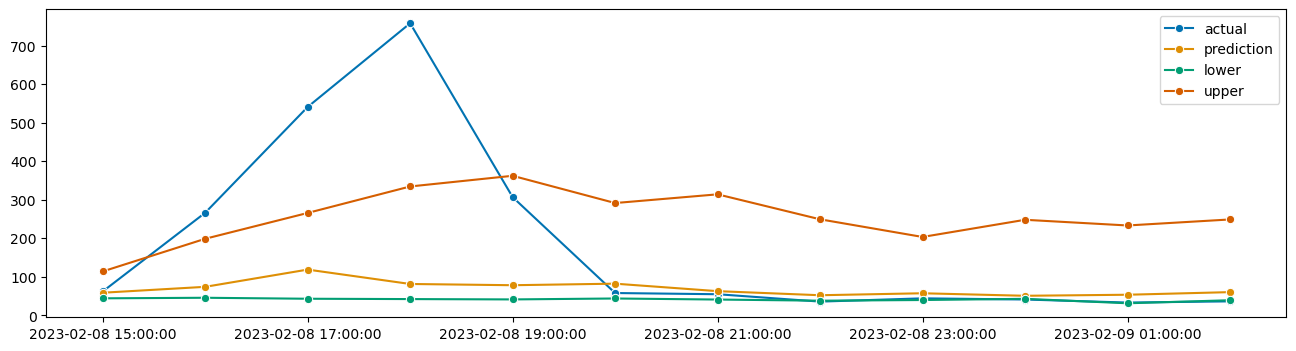

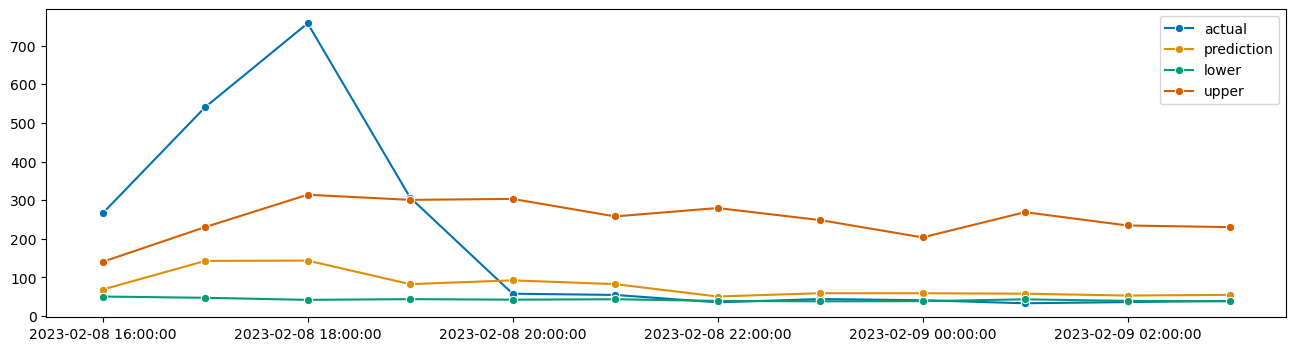

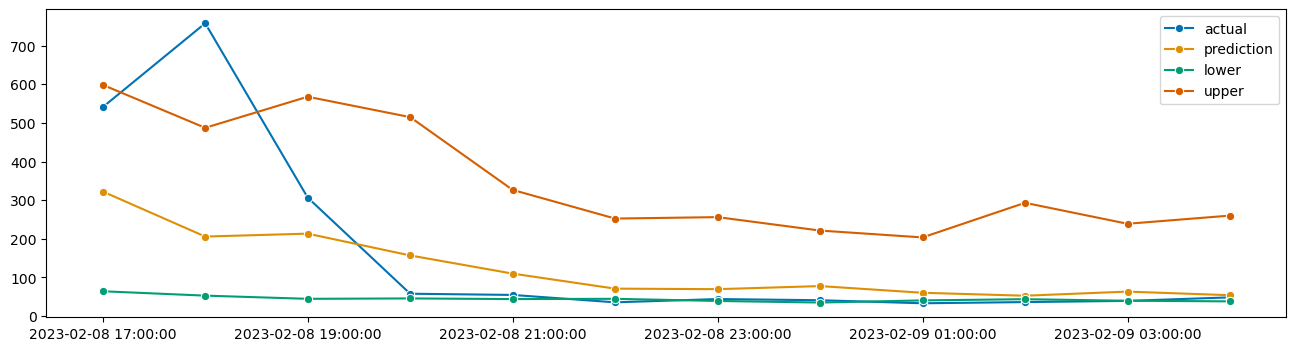

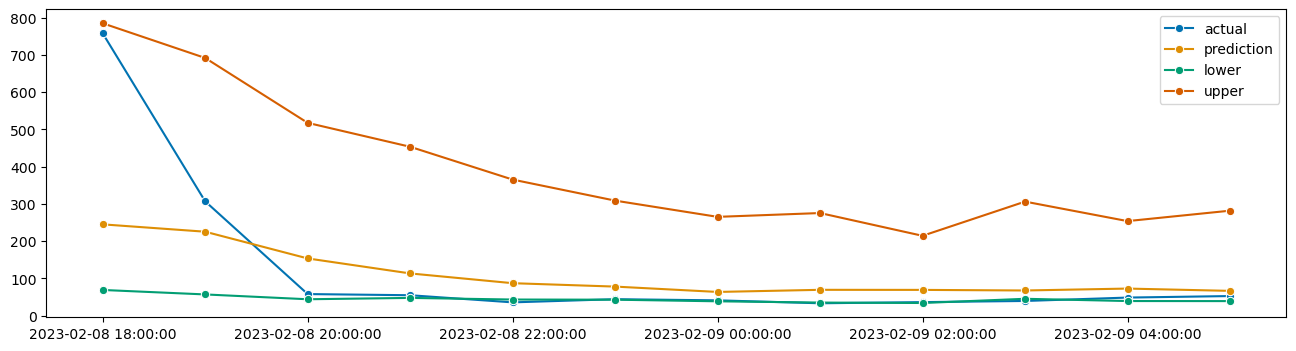

In [31]:
# plot the highest price folds
for i in range(len(highest_price_folds)):
    fig, ax = plot_series(highest_price_folds[i], highest_price_folds_predictions[i], highest_price_folds_low[i], highest_price_folds_high[i], labels=["actual", "prediction", "lower", "upper"])

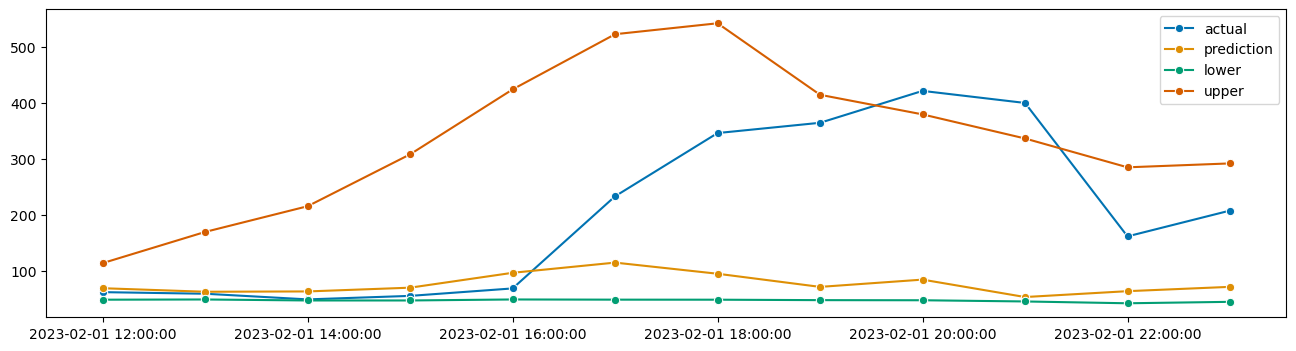

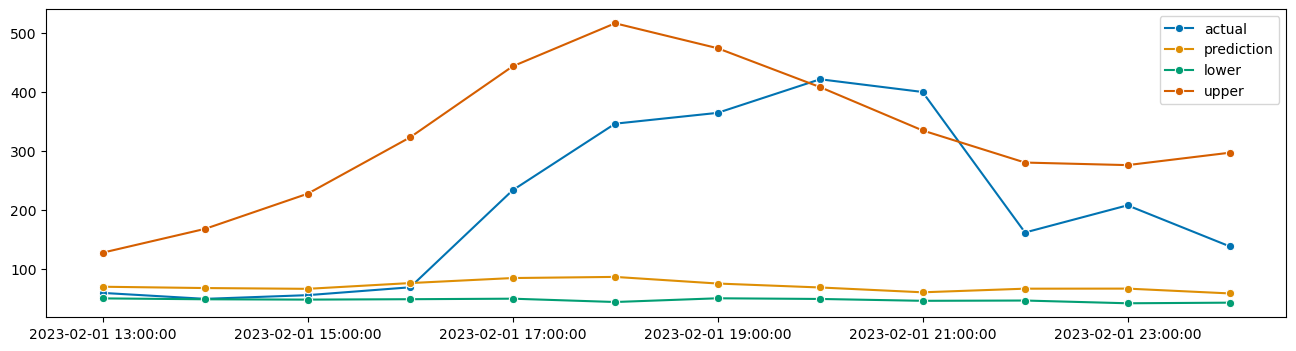

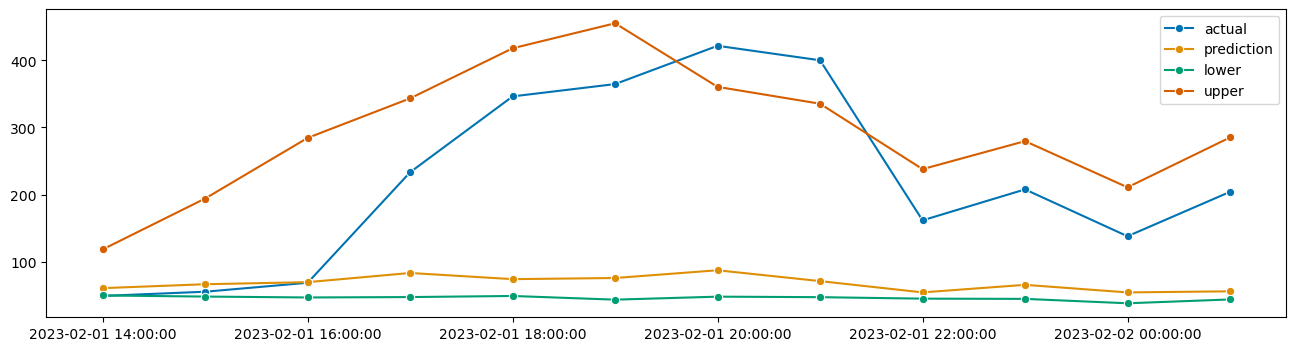

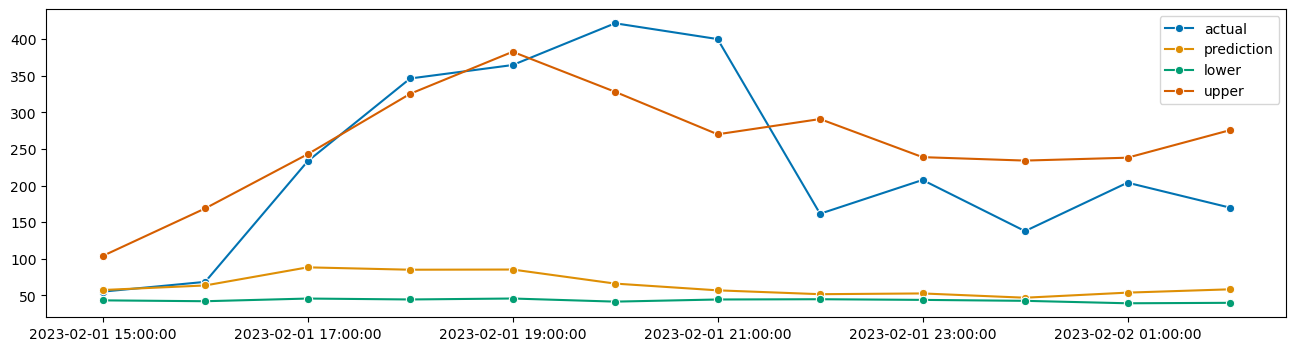

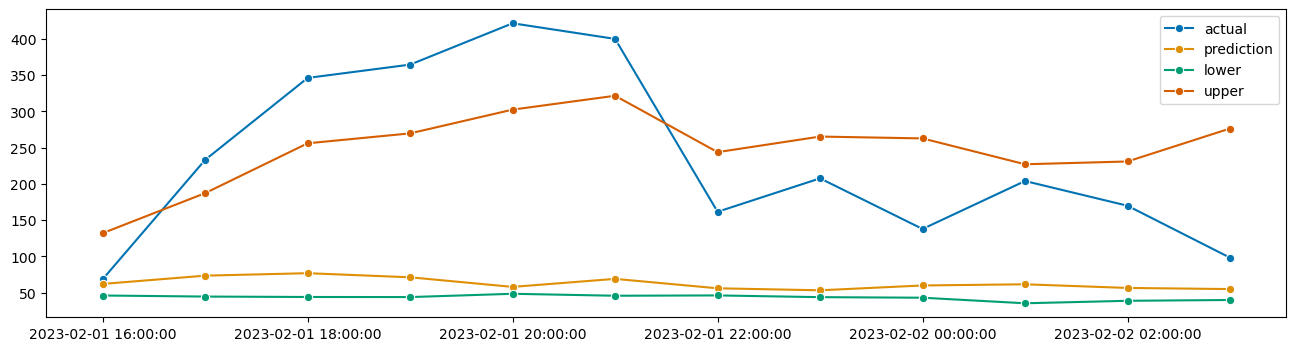

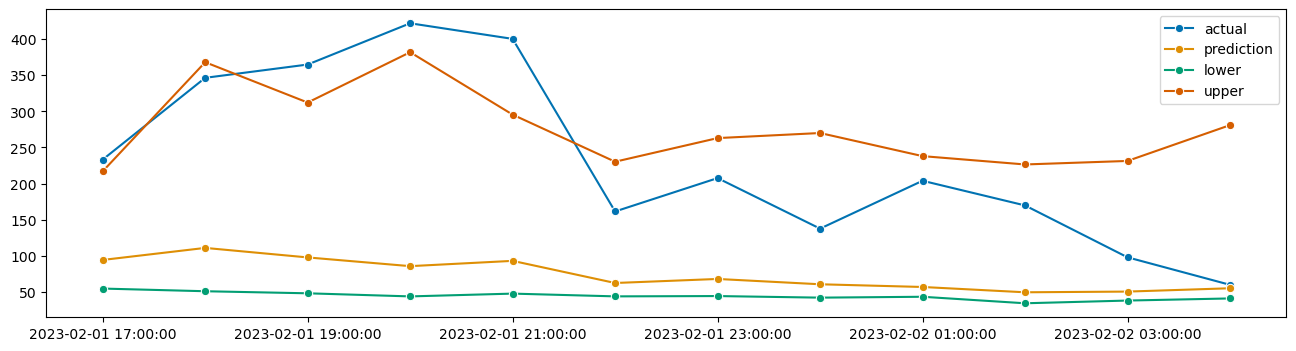

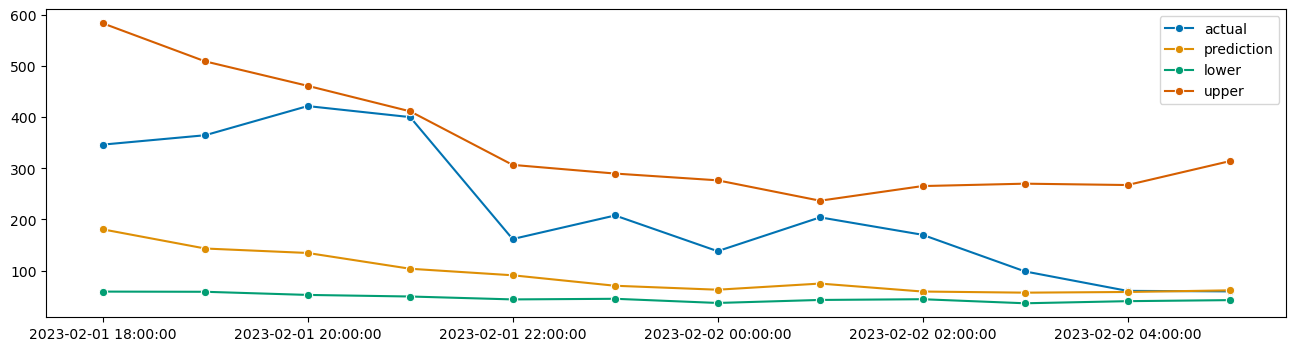

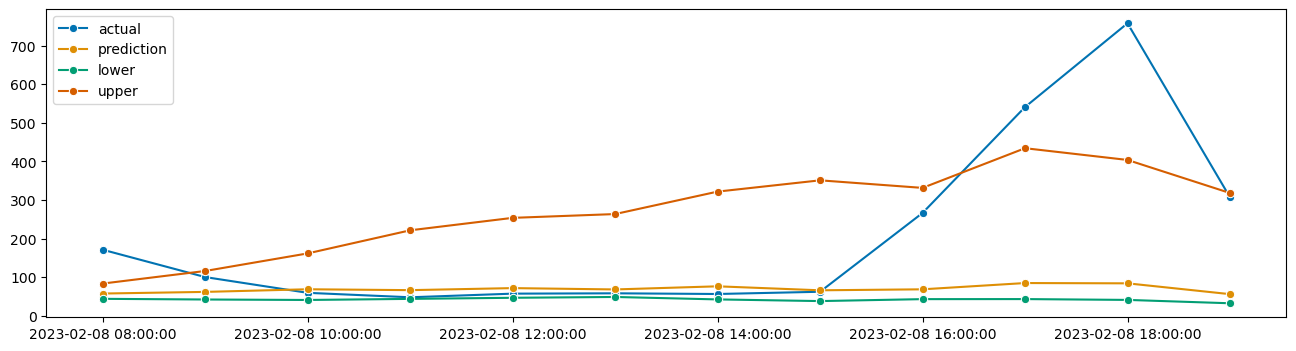

In [29]:
# plot the highest price folds
for i in range(len(highest_price_folds)):
    fig, ax = plot_series(highest_price_folds[i], highest_price_folds_predictions[i], highest_price_folds_low[i], highest_price_folds_high[i], labels=["actual", "prediction", "lower", "upper"])

In [17]:
# plot first 5 folds
# for i in range(20):
#     fig, ax = plot_series(
#         fold_actuals[-i], fold_predictions_list[-i], fold_predictions_low_list[-i], fold_predictions_high_list[-i], labels=["Predictions", "Actuals", "Lower", "Upper"]
#     )